# Community Detection

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering
from node2vec import Node2Vec as n2v

## Create Network

In [3]:
def generate_graph_deg_dist(deg_dist, n):
    '''
    This function will generate a networkx graph G based on a degree distribution
    provided by the user.
    
    params:
        deg_dist (Dictionary) : The key will be the degree and the value is the probability
                                of a node having that degree. The probabilities must sum to
                                1
        n (Integer) : The number of nodes you want the graph to yield
                          
    example:
        G = generate_graph_deg_dist(
                deg_dist = {
                    6:0.2,
                    3:0.14,
                    8:0.35,
                    4:0.3,
                    11:0.01
                },
                n = 1000
        )
    '''
    deg = list(deg_dist.keys())
    proba = list(deg_dist.values())
    if sum(proba) == 1.:
        deg_sequence = np.random.choice(
            deg,
            n,
            proba
        )
        return nx.configuration_model(deg_sequence)
    raise ValueError("Probabilities do not equal to 1")
    
G = generate_graph_deg_dist(
        deg_dist = {
            6:0.2,
            3:0.14,
            8:0.35,
            4:0.3,
            11:0.01
        },
        n = 150
)

print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 150
Number of edges: 470
Average degree:   6.2667


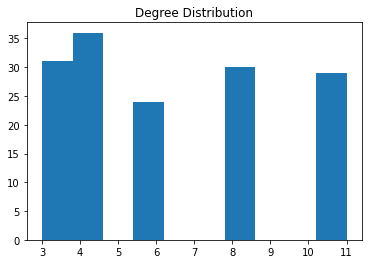

In [4]:
# visualize degree distribution
plt.clf()
plt.hist(list(dict(G.degree()).values()))
plt.title('Degree Distribution')
plt.show()

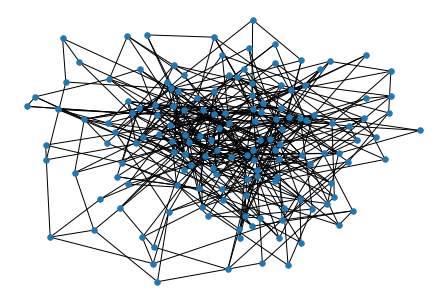

In [5]:
nx.draw(G, node_size = 30)

## Algorithmic Community Detection  
There are many algorithmic algorithms associated with community detection on networks. In this tutorial I will cover the Greedy and Girvan Newman's approach to community detection. There are many other algorithms (like Louvaine's algorithm) which does community detection on networks and I highly encourage you to research and implement those as well. You can find a lot of them here in the NetworkX [documentation](https://networkx.org/documentation/stable/reference/algorithms/community.html) [1]. I will go over the intution and python implementation of these two algorithms and see how they differ on the network in comparison to a semi-supervised machine learning approach. 

## Apply Node2Vec

In [6]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(
  G,
  dimensions=16
)

mdl = g_emb.fit(
    vector_size = 16,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

Computing transition probabilities:   0%|          | 0/150 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


## Generate Embeddings

In [7]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

## Spectral Clustering

In [8]:
X = emb_df.values

In [9]:
clustering = SpectralClustering(
    n_clusters=5, 
    assign_labels='discretize',
    random_state=0
).fit(X)

In [10]:
clustering

SpectralClustering(assign_labels='discretize', n_clusters=5, random_state=0)

## Identify Communities

In [11]:
comm_dct = dict(zip(emb_df.index, clustering.labels_))

In [12]:
color_map = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'orange',
    3 : 'green', 
    4 : 'pink'
}

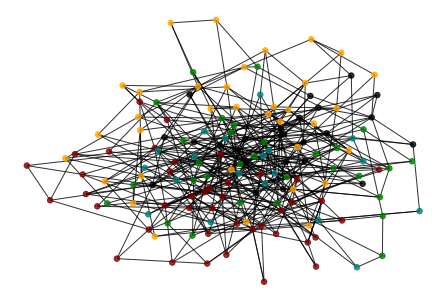

In [13]:
unique_coms = np.unique(list(comm_dct.values()))
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'black', 
    3 : 'orange',
    4 : 'green',
    5 : 'yellow'
}

node_cmap = [cmap[v] for _,v in comm_dct.items()]

pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 30, alpha = 0.8, node_color=node_cmap)
plt.show()

## Concluding Remarks

## Resources
- [1] https://networkx.org/documentation/stable/reference/algorithms/community.html

---